In [1]:
# Import the necessary python packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

# Import datetime
from datetime import datetime

# For kinship and pedigree
import PyAGH
import graphviz

# Import API
import urllib.request, json, csv

# Generate the main dataframe

In [2]:
# Remove birds with no Dam or no Sire
# Define a function that drops rows
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

# Use the function:
# data = filter_rows_by_values(data, "sire", [None])

In [3]:
# Import the birds dataset
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/pedigree/?species=zebf") as url:
    data = pd.read_json(url)

# Clean up
data["uuid"] = data["uuid"].str[:6]
data["name"] = data["name"].str[5:]
data["sire"] = data["sire"].str[5:]
data["dam"] = data["dam"].str[5:]

# replace 'None' by 'origin' in sire/dam
data["sire"] = data["sire"].replace({None: "Origin"})
data["dam"] = data["dam"].replace({None: "Origin"})

In [4]:
# Import reserved_by
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/animals/?reserved_by=melizalab") as url:
    reservation = pd.read_json(url)

reservation = reservation[["uuid", "reserved_by"]]
reservation["uuid"] = reservation["uuid"].str[:6]

reservation = pd.merge(data, reservation, on=["uuid"])
reservation

,uuid,name,sire,dam,sex,alive,plumage,acquired_on,reserved_by
0,566d97,blue_201,blue_72,blue_113,F,False,gray,2017-04-02,melizalab
1,4a36fc,bronze_144,Origin,Origin,F,False,gray,2017-10-14,melizalab
2,8f1932,cobalt_12,purple_23,purple_77,F,False,silver,2021-02-28,melizalab
3,33ad5c,cobalt_25,purple_29,cobalt_10,F,False,gray,2021-06-21,melizalab
4,745712,cobalt_26,purple_83,cobalt_199,M,False,None,2021-06-22,melizalab
...,...,...,...,...,...,...,...,...,...
80,b3e583,purple_83,green_14,bronze_144,M,False,gray,2019-12-17,melizalab
81,fb4a53,purple_92,blue_2,blue_8,M,False,silver,2016-10-18,melizalab
82,9469b8,purple_108,red_264,purple_106,M,False,gray,2020-08-12,melizalab
83,20bc8a,purple_128,red_216,orange_143,M,False,gray,2020-10-19,melizalab


In [5]:
# Calculate the age for all the birds
today = datetime.today()

# Convert acquisition into a timestamp
birth = pd.to_datetime(data['acquired_on'])

# Calculate
data["age"] = (today - birth).dt.days

# Convert in 0 & 1
data = data*1

for index, row in data.iterrows():
    if row['alive'] == 0:
        data.at[index, 'age'] = "NA"

data

/tmp/ipykernel_135599/2812513485.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.at[index, 'age'] = "NA"


,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age
0,f32cfc,blue_1,Origin,Origin,F,0,NaN,2014-04-09,NA
1,fc9219,blue_2,Origin,Origin,M,0,NaN,2014-04-09,NA
2,b44ef6,blue_3,Origin,Origin,M,0,NaN,2014-04-09,NA
3,55de87,blue_4,Origin,Origin,M,0,NaN,2014-04-09,NA
4,fafe58,blue_5,Origin,Origin,F,0,NaN,2014-04-09,NA
...,...,...,...,...,...,...,...,...,...
380,9958b8,9958b866,cobalt_126,ruby_236,U,1,NaN,2024-12-26,19.0
381,90a380,90a380a0,cobalt_302,ruby_269,U,1,NaN,2024-12-30,15.0
382,8a41fd,8a41fde6,ruby_270,ruby_256,U,1,NaN,2025-01-02,12.0
383,7b0473,7b04739c,ruby_270,ruby_256,U,1,NaN,2024-12-29,16.0


In [6]:
alive_birds = []

for index, row in data.iterrows():
    if row['alive'] == 1 :
        alive_birds.append(row)

alive_birds = pd.DataFrame(alive_birds) # Create a DataFrame of alive birds only

alive_birds

,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age
74,9a09b0,cobalt_110,cobalt_57,purple_174,F,1,fawn,2023-01-11,734.0
75,cec999,cobalt_114,purple_104,cobalt_84,F,1,fawn,2023-02-17,697.0
77,a9167f,cobalt_122,cobalt_32,ruby_203,M,1,gray,2023-02-09,705.0
79,abad48,cobalt_126,cobalt_206,purple_179,M,1,gray,2023-02-21,693.0
81,6a3b1f,cobalt_137,cobalt_35,cobalt_10,M,1,gray,2023-03-21,665.0
...,...,...,...,...,...,...,...,...,...
380,9958b8,9958b866,cobalt_126,ruby_236,U,1,NaN,2024-12-26,19.0
381,90a380,90a380a0,cobalt_302,ruby_269,U,1,NaN,2024-12-30,15.0
382,8a41fd,8a41fde6,ruby_270,ruby_256,U,1,NaN,2025-01-02,12.0
383,7b0473,7b04739c,ruby_270,ruby_256,U,1,NaN,2024-12-29,16.0


Example of a Fertility Score Calculation (Hypothetical)

An example calculation could use specific thresholds for each factor. Suppose each of the factors contributes a score between 0 to 10, with higher scores representing better fertility potential. The formula might look like this:
F=(10−A)+H+(10−B)+L+M+S
F=(10−A)+H+(10−B)+L+M+S

Where:

    AA = Age (e.g., 30 might yield 7 points, while 40 yields 3 points)
    HH = Hormonal health (based on specific tests)
    BB = BMI (e.g., a BMI of 22 could yield 9 points, and 30 could yield 3 points)
    LL = Lifestyle (e.g., non-smoking, healthy diet = 8 points)
    MM = Medical history (e.g., no conditions = 10 points)
    SS = Semen analysis (e.g., normal sperm count = 10 points)

## Calculate kinship

In [7]:
ped = pd.DataFrame()

ped["id"] = data["name"]
ped["sire"] = data["sire"]
ped["dam"] = data["dam"]

ped = filter_rows_by_values(ped, "sire", ["Origin"]) # Filter out the birds brought from the store
ped

,id,sire,dam
16,blue_20,blue_11,blue_12
17,blue_30,blue_7,blue_13
18,blue_31,blue_7,blue_13
19,blue_34,blue_7,blue_15
20,blue_35,blue_7,blue_15
...,...,...,...
380,9958b866,cobalt_126,ruby_236
381,90a380a0,cobalt_302,ruby_269
382,8a41fde6,ruby_270,ruby_256
383,7b04739c,ruby_270,ruby_256


In [23]:
ped_selected = PyAGH.selectPed(data=ped, id=["8a41fde6"], generation=5) # Print 3 generations of the chosen bird
ped_selected = PyAGH.sortPed(ped_selected)

ped_selected

,id,sire,dam
0,orange_89,0,0
1,blue_2,0,0
2,e1a98d00,0,0
3,green_14,0,0
4,purple_23,0,0
5,red_192,0,0
6,red_180,0,0
7,orange_111,0,0
8,blue_8,0,0
9,6b3dbce1,0,0


In [24]:
sort_ped = PyAGH.sortPed(ped_selected) # Sort the pedigree first
A = PyAGH.makeA(sort_ped)

In [25]:
coef_inbreeding = PyAGH.coefInbreeding(A)
coef_inbreeding

,ID,F
0,orange_89,0.000000
1,blue_2,0.000000
2,e1a98d00,0.000000
3,green_14,0.000000
4,purple_23,0.000000
5,red_192,0.000000
6,red_180,0.000000
7,orange_111,0.000000
8,blue_8,0.000000
9,6b3dbce1,0.000000


In [26]:
coef_kinship = PyAGH.coefKinship(A)
coef_kinship

,ID1,ID2,r
0,orange_89,orange_89,1.000000
1,orange_89,blue_2,0.000000
2,orange_89,e1a98d00,0.000000
3,orange_89,green_14,0.000000
4,orange_89,purple_23,0.000000
...,...,...,...
775,ruby_270,ruby_256,0.093750
776,ruby_270,8a41fde6,0.534491
777,ruby_256,ruby_256,1.000000
778,ruby_256,8a41fde6,0.534491


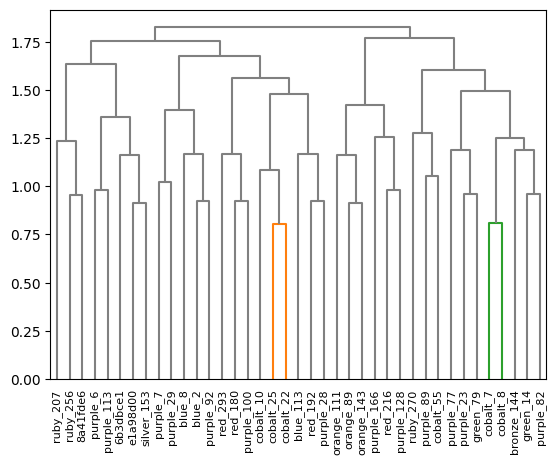

In [27]:
cluster_example = PyAGH.cluster(A)
plt.xticks(rotation=90)
plt.savefig('../output/cluster_example.png', facecolor='w', dpi=300)

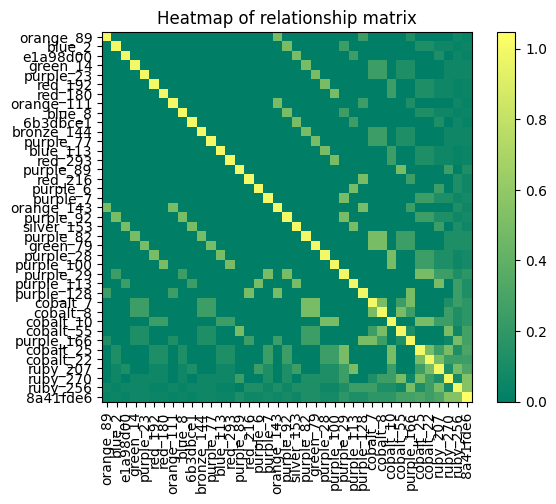

In [28]:
heatmap_example = PyAGH.heat(A)
plt.xticks(rotation=90)
plt.savefig('../output/heatmap_example.png', facecolor='w',dpi=500)

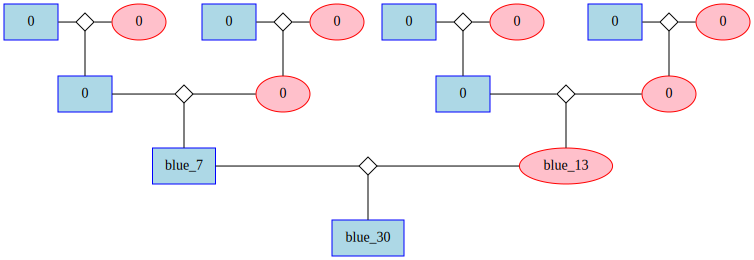

In [29]:
ped_selected = PyAGH.selectPed(data=ped,id=['blue_30'], generation=3) # Print selected number of generation of the bird
p = PyAGH.gragh(ped_selected)
graphviz.Source(p)

# Mastersheet events + birds

In [30]:
# Import the birds used for an experiment
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/events/?status=used") as url:
    used_birds = pd.read_json(url)

# Import the birds that died unexpectedly
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/events/?status=died") as url:
    died_birds = pd.read_json(url)

In [31]:
# Clean up
used_birds["uuid"] = used_birds["animal"].str[:6]
died_birds["uuid"] = died_birds["animal"].str[:6]

used_birds

,id,animal,date,status,location,description,entered_by,measurements,uuid
0,24278,2c47aaa1-dba5-47f7-b670-d3d78946154b,2025-01-14,used for slices,NaN,,bellanger,[],2c47aa
1,24260,f4741d6a-831b-4028-ab60-a0807d286677,2025-01-10,used for anatomy,NaN,Perfused,tbyron,[],f4741d
2,24226,1cb3fafb-7717-437a-a32d-323776a93988,2025-01-08,used for slices,NaN,ben and ram used for slices,hfugate,[],1cb3fa
3,24169,c526878b-acb7-45d8-aa15-4c58847b9cb4,2025-01-07,used for slices,NaN,,bellanger,[],c52687
4,24156,05320387-4eb9-4aa1-a94b-1facbb9055ee,2025-01-03,used for in vivo,NaN,,melizalab,"[{'measure': 'weight', 'value': 12.0, 'units':...",053203
...,...,...,...,...,...,...,...,...,...
95,22317,389e7f1c-51b5-45a3-9e8d-dcdc19a1f19a,2024-09-11,used for slices,NaN,,bellanger,[],389e7f
96,22299,e088b42d-107e-4149-b078-35eb7fdc8742,2024-09-10,used for slices,NaN,,bellanger,[],e088b4
97,22297,a09494ff-1560-415f-95f3-67f38bf1033b,2024-09-09,used for slices,NaN,,bellanger,[],a09494
98,22296,a09494ff-1560-415f-95f3-67f38bf1033b,2024-09-09,used for slices,NaN,Patched for attempted sequencing- first bird,rallapalli,[],a09494


In [32]:
# Add the list of events to the mastersheet
used_birds_ = pd.merge(
    data, used_birds, on=["uuid"]
)

died_birds_ = pd.merge(
    data, died_birds, on=["uuid"]
)

# Concatenate into a mastersheet
frames = [used_birds_, died_birds_]
mastersheet = pd.concat(frames)

In [33]:
mastersheet

,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age,id,animal,date,status,location,description,entered_by,measurements
0,33ad5c,cobalt_25,purple_29,cobalt_10,F,0,gray,2021-06-21,NA,22765,33ad5cef-f87d-41a2-8ccc-e9700e34a560,2024-09-25,used for anatomy,NaN,culled due to age/to make room for new birds,hfugate,[]
1,415c4a,cobalt_32,cobalt_5,cobalt_11,M,0,pied,2021-07-03,NA,22295,415c4aa4-65f2-4e96-86a9-26becac83eb5,2024-09-07,used for in vivo,NaN,perfused,afy9tp,[]
2,ef618d,cobalt_55,purple_89,cobalt_8,M,0,gray,2021-07-29,NA,22764,ef618d79-2ec4-40f3-b24c-80960b5b0a76,2024-09-25,used for anatomy,NaN,culled due to age/ to make room for new birds,hfugate,[]
3,f30e1b,cobalt_175,cobalt_52,cobalt_59,F,0,fawn,2023-04-26,NA,23557,f30e1bc5-5752-4cc6-a985-91cb8f2794c5,2024-11-08,used for anatomy,NaN,Injured herself and broke her femur. Had to be...,bellanger,[]
4,ada093,cobalt_318,cobalt_200,cobalt_180,M,0,gray,2024-02-17,NA,23213,ada093d8-0a27-4b84-baaf-d19fec3ce731,2024-10-25,used for in vivo,NaN,ar-synfam,bao.le,[]
5,49977a,cobalt_333,purple_166,ruby_207,M,0,gray,2024-02-26,NA,23194,49977aec-2d37-4dc2-a4fe-25f4409013a4,2024-10-24,used for anatomy,NaN,"Culled to make room in colony, was chosen due ...",hfugate,[]
6,21af3e,ruby_254,cobalt_57,purple_174,F,0,gray,2023-08-09,NA,23233,21af3ed6-09ff-4ff6-ac25-42ee9ce5acca,2024-10-28,used for anatomy,NaN,Culled for space and due to being retired from...,hfugate,[]
7,cbecce,ruby_262,cobalt_80,purple_190,M,0,gray,2023-09-06,NA,23195,cbecceae-e340-4728-848c-de9d59306d86,2024-10-24,used for anatomy,NaN,"Culled to make room in colony, was chosen due ...",hfugate,[]
8,2aa653,ruby_279,cobalt_16,cobalt_79,M,0,gray,2023-10-15,NA,22395,2aa653e5-5b44-487c-9bed-e3997d3de803,2024-09-16,used for in vivo,NaN,ar,bao.le,[]
0,b9bf3c,cobalt_80,purple_104,cobalt_158,M,0,gray,2021-10-08,NA,21950,b9bf3c4a-c16b-42ef-bf7e-159e8e21aa15,2024-08-09,died,None,Taken for euthanasia and necropsy,hfugate,[]


# Add kinship data to the mastersheet

In [19]:
sort_ped = PyAGH.sortPed(ped) # Select all the birds for analysis instead of a given bird
A = PyAGH.makeA(sort_ped)

coef_inbreeding = PyAGH.coefInbreeding(A)
coef_kinship = PyAGH.coefKinship(A)

# Making it shinny
coef_inbreeding["name"] = coef_inbreeding["ID"]
coef_inbreeding["coef_inbreeding"] = coef_inbreeding["F"]
coef_inbreeding = coef_inbreeding[["name", "coef_inbreeding"]]

In [20]:
mastersheet = pd.merge(
    mastersheet, coef_inbreeding, on=["name"]
)

In [21]:
mastersheet

,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age,id,animal,date,status,location,description,entered_by,measurements,coef_inbreeding
0,33ad5c,cobalt_25,purple_29,cobalt_10,F,0,gray,2021-06-21,NA,22765,33ad5cef-f87d-41a2-8ccc-e9700e34a560,2024-09-25,used for anatomy,NaN,culled due to age/to make room for new birds,hfugate,[],0.031250
1,415c4a,cobalt_32,cobalt_5,cobalt_11,M,0,pied,2021-07-03,NA,22295,415c4aa4-65f2-4e96-86a9-26becac83eb5,2024-09-07,used for in vivo,NaN,perfused,afy9tp,[],-0.000000
2,ef618d,cobalt_55,purple_89,cobalt_8,M,0,gray,2021-07-29,NA,22764,ef618d79-2ec4-40f3-b24c-80960b5b0a76,2024-09-25,used for anatomy,NaN,culled due to age/ to make room for new birds,hfugate,[],-0.000000
3,f30e1b,cobalt_175,cobalt_52,cobalt_59,F,0,fawn,2023-04-26,NA,23557,f30e1bc5-5752-4cc6-a985-91cb8f2794c5,2024-11-08,used for anatomy,NaN,Injured herself and broke her femur. Had to be...,bellanger,[],0.007812
4,ada093,cobalt_318,cobalt_200,cobalt_180,M,0,gray,2024-02-17,NA,23213,ada093d8-0a27-4b84-baaf-d19fec3ce731,2024-10-25,used for in vivo,NaN,ar-synfam,bao.le,[],0.013794
5,49977a,cobalt_333,purple_166,ruby_207,M,0,gray,2024-02-26,NA,23194,49977aec-2d37-4dc2-a4fe-25f4409013a4,2024-10-24,used for anatomy,NaN,"Culled to make room in colony, was chosen due ...",hfugate,[],0.006226
6,21af3e,ruby_254,cobalt_57,purple_174,F,0,gray,2023-08-09,NA,23233,21af3ed6-09ff-4ff6-ac25-42ee9ce5acca,2024-10-28,used for anatomy,NaN,Culled for space and due to being retired from...,hfugate,[],0.007812
7,cbecce,ruby_262,cobalt_80,purple_190,M,0,gray,2023-09-06,NA,23195,cbecceae-e340-4728-848c-de9d59306d86,2024-10-24,used for anatomy,NaN,"Culled to make room in colony, was chosen due ...",hfugate,[],0.000244
8,2aa653,ruby_279,cobalt_16,cobalt_79,M,0,gray,2023-10-15,NA,22395,2aa653e5-5b44-487c-9bed-e3997d3de803,2024-09-16,used for in vivo,NaN,ar,bao.le,[],0.016113
9,b9bf3c,cobalt_80,purple_104,cobalt_158,M,0,gray,2021-10-08,NA,21950,b9bf3c4a-c16b-42ef-bf7e-159e8e21aa15,2024-08-09,died,None,Taken for euthanasia and necropsy,hfugate,[],-0.000000
